In [1]:
# Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, stddev, lead
from pyspark.sql.functions import lag, when, avg
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, GBTRegressor, RandomForestRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# Initialize SparkSession
spark = SparkSession.builder.appName("Stock Data Analysis").getOrCreate()

25/05/04 16:28:08 WARN Utils: Your hostname, Murats-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.10.18.39 instead (on interface en0)
25/05/04 16:28:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/04 16:28:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Load or Create Dataset
try:
  # Load dataset
    all_df = spark.read.csv("nasdaq100.csv", header=True, inferSchema=True)
    all_df = all_df.filter((col("date") <= "2022-12-31"))
except:
    # Create Dataset
    
    # Dataset directory
    dataset_directory = "nasdaq100"
    
    # Get CSV file names
    csv_files = [file for file in os.listdir(dataset_directory) if file.endswith('.csv')]
    
    # Select years
    selected_years = list(range(2011, 2026))
    
    # Load and filter data
    all_dfs = pd.DataFrame()
    
    # Load CSV Files
    for file in csv_files:
        file_path = os.path.join(dataset_directory, file)
        temp_df = pd.read_csv(file_path)
        temp_df['date'] = pd.to_datetime(temp_df['date'], errors='coerce')
        temp_df = temp_df[temp_df['date'].dt.year.isin(selected_years)]
        all_dfs = pd.concat([all_dfs, temp_df], ignore_index=True)
    
    # Save the combined DataFrame
    all_dfs.to_csv('nasdaq100.csv', index=False) 
    # Load dataset
    all_df = spark.read.csv("nasdaq100.csv", header=True, inferSchema=True)
    all_df = all_df.filter((col("date") <= "2022-12-31"))

In [4]:
# Load dataset and filter
all_df = spark.read.csv("nasdaq100.csv", header=True, inferSchema=True)
all_df = all_df.filter((col("date") <= "2022-12-31"))

In [5]:
# Inspection of data
descriptive_cols = ["close", "open", "high", "low"]
for colname in descriptive_cols:
    all_df.select(colname).describe().show()

+-------+------------------+
|summary|             close|
+-------+------------------+
|  count|            263480|
|   mean|115.54119099916544|
| stddev|202.41061318081347|
|    min|           1.45533|
|    max|           2703.26|
+-------+------------------+

+-------+------------------+
|summary|              open|
+-------+------------------+
|  count|            263480|
|   mean|115.54108986340465|
| stddev|202.50511793060733|
|    min|             1.452|
|    max|            2680.0|
+-------+------------------+

+-------+------------------+
|summary|              high|
+-------+------------------+
|  count|            263480|
|   mean|117.05544641407486|
| stddev| 205.1274305304005|
|    min|           1.48467|
|    max|           2715.66|
+-------+------------------+

+-------+------------------+
|summary|               low|
+-------+------------------+
|  count|            263480|
|   mean|113.97302263405027|
| stddev| 199.7183831763865|
|    min|           1.40733|
|    max|  

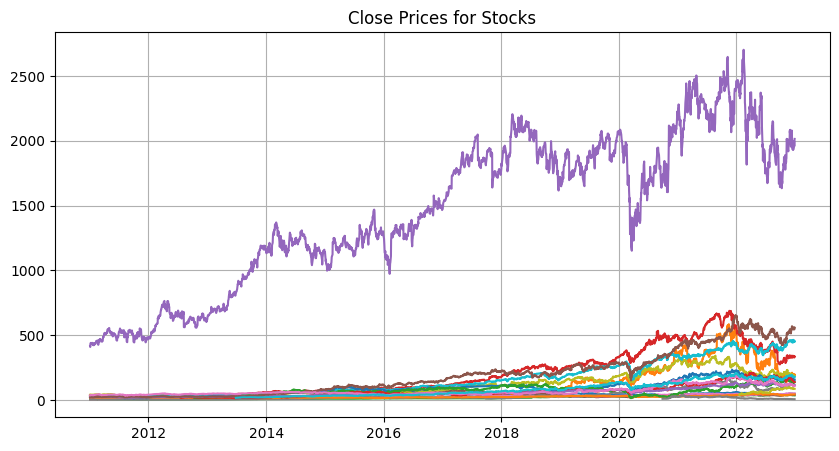

In [6]:
# Plotting raw and log-transformed close prices for sample tickers
pandas_df = all_df.toPandas()
unique_tickers = pandas_df['ticker'].unique()

plt.figure(figsize=(10, 5))
for idx, ticker in enumerate(unique_tickers):
    if idx % 5 == 0:
        ticker_df = pandas_df[pandas_df['ticker'] == ticker]
        plt.plot(ticker_df['date'], ticker_df['close'])
plt.title('Close Prices for Stocks'); 
plt.grid(True); 
plt.show()

In [7]:
# Split data into periods
train_df = all_df.filter(col("date") <= "2016-12-31")
test_period = all_df.filter((col("date") >= "2017-01-01") & (col("date") <= "2017-12-31"))
trade_war_period = all_df.filter((col("date") >= "2018-01-01") & (col("date") <= "2019-12-31"))
covid_period = all_df.filter((col("date") >= "2020-02-01") & (col("date") <= "2020-08-31"))
ukraine_period = all_df.filter((col("date") >= "2022-02-01") & (col("date") <= "2022-12-31"))

In [8]:
# Feature Engineering Function
def create_dataset_spark(df):
    window_spec_5 = Window.partitionBy("ticker").orderBy("date").rowsBetween(-4, 0)
    window_spec_10 = Window.partitionBy("ticker").orderBy("date").rowsBetween(-9, 0)
    window_spec = Window.partitionBy("ticker").orderBy("date")

    df = df.withColumn("ma_5", avg("close").over(window_spec_5)) \
           .withColumn("ma_10", avg("close").over(window_spec_10)) \
           .withColumn("volatility_5", stddev("close").over(window_spec_5)) \
           .withColumn("volatility_10", stddev("close").over(window_spec_10)) \
           .withColumn("close_lag1", lag("close", 1).over(window_spec)) \
           .withColumn("open_lag1", lag("open", 1).over(window_spec)) \
           .withColumn("high_lag1", lag("high", 1).over(window_spec)) \
           .withColumn("low_lag1", lag("low", 1).over(window_spec)) \
           .withColumn("return_open_close", (col("close") - col("open")) / col("open")) \
           .withColumn("return_high_low", (col("high") - col("low")) / col("open")) \
           .withColumn("return_close_lag1", (col("close") - col("close_lag1")) / col("close_lag1")) \
           .withColumn("label_regress", lead("close", 1).over(window_spec)) \
           .withColumn("label_class", when(col("label_regress") > col("close"), 1).otherwise(0)) \
           .withColumn("label_return", (col("label_regress") - col("close")) / col("close"))

    feature_columns = ["open", "high", "low", "close", "ma_5", "ma_10", "volatility_5", "volatility_10",
                       "close_lag1", "open_lag1", "high_lag1", "low_lag1",
                       "return_open_close", "return_high_low", "return_close_lag1"]

    df = df.dropna(subset=feature_columns + ['label_regress', 'label_class', 'label_return'])
    assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
    df = assembler.transform(df)
    return df.select('features', 'label_regress', 'label_class', 'label_return')

In [9]:
# Create training and test datasets
train_sdf = create_dataset_spark(train_df)
test_sdf = create_dataset_spark(test_period)
trade_war = create_dataset_spark(trade_war_period)
covid = create_dataset_spark(covid_period)
ukraine = create_dataset_spark(ukraine_period)

In [10]:
# Feature Scaling
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(train_sdf)
train_sdf = scaler_model.transform(train_sdf)
test_sdf = scaler_model.transform(test_sdf)
trade_war = scaler_model.transform(trade_war)
covid = scaler_model.transform(covid)
ukraine = scaler_model.transform(ukraine)

25/05/04 16:28:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.



Training Linear Regression...


25/05/04 16:28:20 WARN Instrumentation: [de73f67c] regParam is zero, which might cause numerical instability and overfitting.
25/05/04 16:28:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/04 16:28:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Linear Regression RMSE during Stable Period: 3.2952527430196485
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      27.2867|27.15140029542622|
|      27.5858|27.29365502400841|
+-------------+-----------------+
only showing top 2 rows

Linear Regression RMSE during Trade War Period: 4.26929274899728
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|      41.1366| 40.93779750409024|
|      41.6001|41.179905532132906|
+-------------+------------------+
only showing top 2 rows

Linear Regression RMSE during COVID Period: 8.436337158219098
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      78.7269|78.39888917091139|
|      79.6511|78.78156209820531|
+-------------+-----------------+
only showing top 2 rows

Linear Regression RMSE during Ukraine War Period: 9.72962279695246
+-------------+------------------+
|label_regress

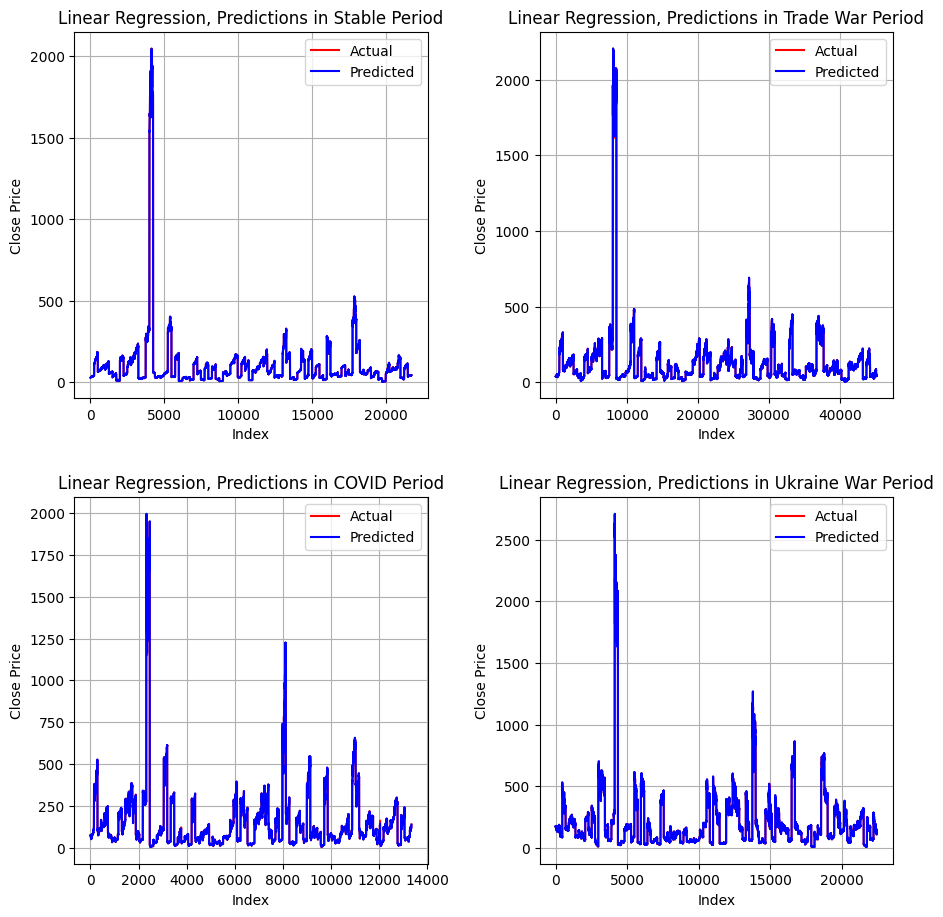


Training GBT Regressor...


GBT Regressor RMSE during Stable Period: 104.7536961702255
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      27.2867|27.24607088436414|
|      27.5858|27.24607088436414|
+-------------+-----------------+
only showing top 2 rows

GBT Regressor RMSE during Trade War Period: 142.9359938383327
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      41.1366|41.22426396459253|
|      41.6001|41.22426396459253|
+-------------+-----------------+
only showing top 2 rows

GBT Regressor RMSE during COVID Period: 163.08995917263306
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      78.7269|81.44132439158543|
|      79.6511|80.19471858120205|
+-------------+-----------------+
only showing top 2 rows

GBT Regressor RMSE during Ukraine War Period: 205.0031752904437
+-------------+------------------+
|label_regress|        prediction|

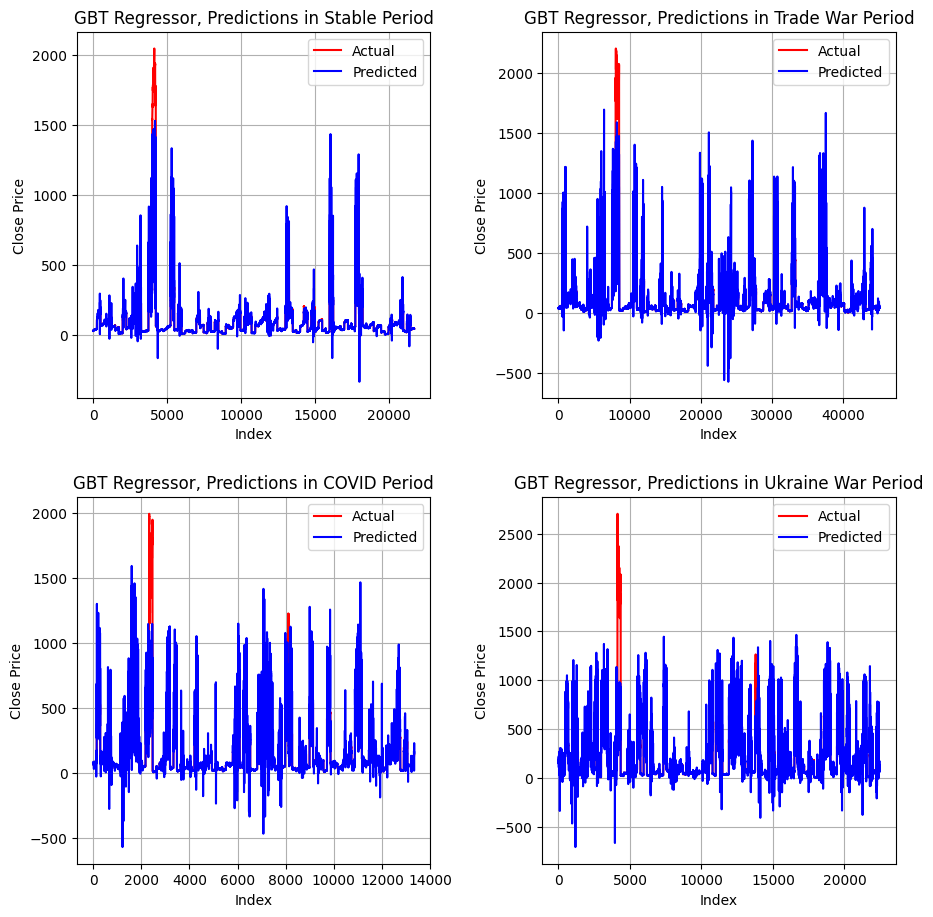


Training Random Forest Regressor...


Random Forest Regressor RMSE during Stable Period: 114.95502489516146
+-------------+---------------+
|label_regress|     prediction|
+-------------+---------------+
|      27.2867|26.023260189472|
|      27.5858|26.023260189472|
+-------------+---------------+
only showing top 2 rows

Random Forest Regressor RMSE during Trade War Period: 142.4262032492709
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      41.1366|41.99744058160763|
|      41.6001|41.99744058160763|
+-------------+-----------------+
only showing top 2 rows

Random Forest Regressor RMSE during COVID Period: 151.1817052666256
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      78.7269|78.15790666482651|
|      79.6511|78.15790666482651|
+-------------+-----------------+
only showing top 2 rows

Random Forest Regressor RMSE during Ukraine War Period: 190.57916076541719
+-------------+------------------+
|labe

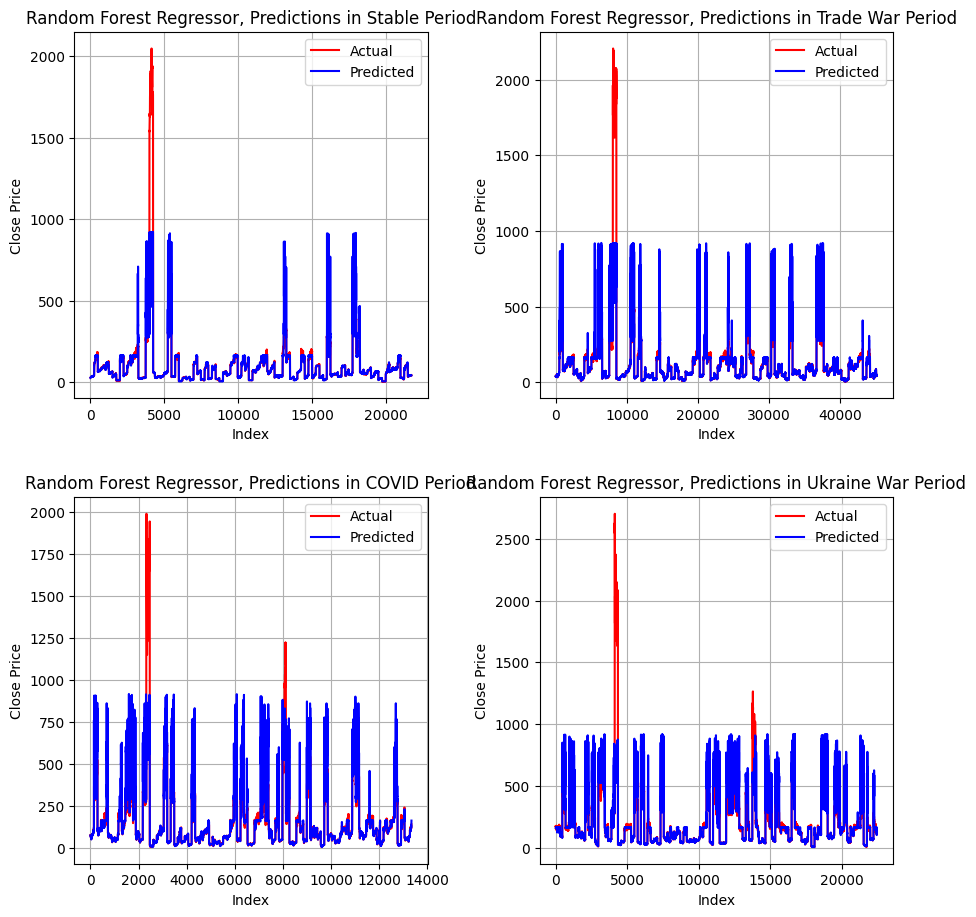


Training Decision Tree Regressor...
Decision Tree Regressor RMSE during Stable Period: 104.16618726484214
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|      27.2867|26.563154589731433|
|      27.5858|26.563154589731433|
+-------------+------------------+
only showing top 2 rows

Decision Tree Regressor RMSE during Trade War Period: 139.02559846860083
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|      41.1366|43.171530305475514|
|      41.6001|43.171530305475514|
+-------------+------------------+
only showing top 2 rows

Decision Tree Regressor RMSE during COVID Period: 154.60755676213918
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      78.7269|77.05528035047033|
|      79.6511|77.05528035047033|
+-------------+-----------------+
only showing top 2 rows

Decision Tree Regressor RMSE during Ukraine War Peri

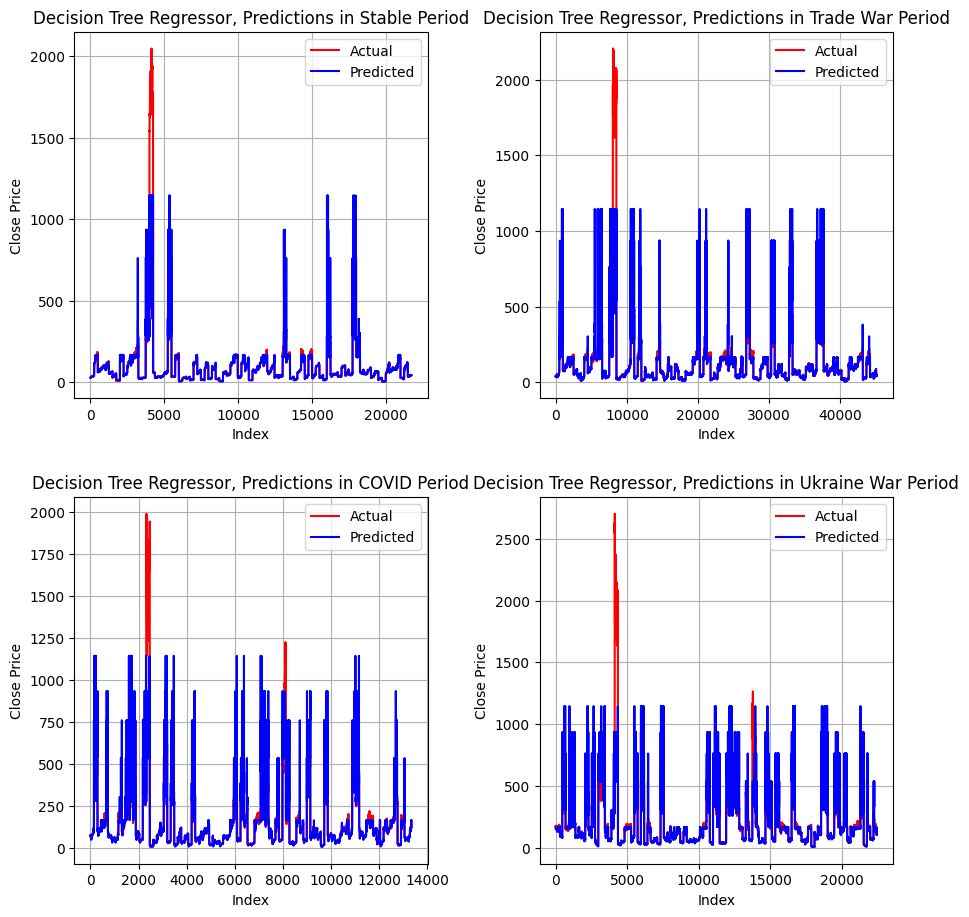

In [11]:
# Train and Evaluate Regressors
regressors = {
    "Linear Regression": LinearRegression(featuresCol="scaled_features", labelCol="label_regress"),
    "GBT Regressor": GBTRegressor(featuresCol="scaled_features", labelCol="label_regress", stepSize=0.5, seed=42),
    "Random Forest Regressor": RandomForestRegressor(featuresCol="scaled_features", labelCol="label_regress", numTrees=100, seed=42),
    "Decision Tree Regressor": DecisionTreeRegressor(featuresCol="scaled_features", labelCol="label_regress")
}

for name, model in regressors.items():
    print(f"\nTraining {name}...")
    reg_model = model.fit(train_sdf)
    reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10)) 
    fig.tight_layout(pad=5.0)
    
    for i, (period_name, period_df) in enumerate(zip(["Stable Period", "Trade War Period", "COVID Period", "Ukraine War Period"], 
                                                     [test_sdf, trade_war, covid, ukraine])):
        preds = reg_model.transform(period_df)
        rmse = reg_eval.evaluate(preds)
        print(f"{name} RMSE during {period_name}: {rmse}")
        preds.select("label_regress", "prediction").show(2)

        # Collect results for plotting
        preds_pd = preds.select('label_regress', 'prediction').toPandas()
        
        # Determine subplot position dynamically
        row, col = divmod(i, 2)  # Find row and column position
        axes[row, col].plot(range(len(preds_pd)), preds_pd['label_regress'], label='Actual', color='red')
        axes[row, col].plot(range(len(preds_pd)), preds_pd['prediction'], label='Predicted', color='blue')
        axes[row, col].set_xlabel('Index')
        axes[row, col].set_ylabel('Close Price')
        axes[row, col].set_title(f"{name}, Predictions in {period_name}")
        axes[row, col].legend()
        axes[row, col].grid(True)
    
    # Display the entire grid figure
    plt.show()